# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import sys 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from utils import clean_database, perform_voting_feature_selection
pd.set_option('display.max_columns', None)

preprocessing_dir = os.path.join('figures','preprocessing', 'MLP2')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)

[Dataset Info] Attack Type Distribution (Counts):
Attack Type
Benign            477716
UDPFlood          457340
HTTPFlood         140812
SlowrateDoS        73124
TCPConnectScan     20052
SYNScan            20043
UDPScan            15906
SYNFlood            9721
ICMPFlood           1155
Name: count, dtype: int64
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attac

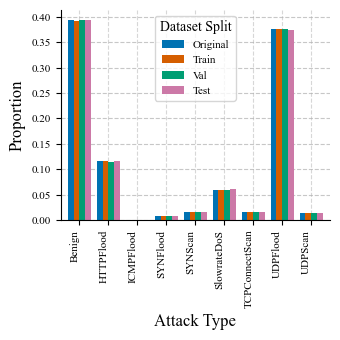

NameError: name 'print_memory_usage' is not defined

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=True, fix_skewness=False)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()


In [ ]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

# Arguments

In [ ]:
n_features_list = [35, 30, 25, 20, 15, 10, 5, 1]
sampling_method = 'None'
plot_distributions = True

# The loop

In [ ]:
# 1. Loop through each configuration
for n in n_features_list:
    print(f"\n{'='*80}")
    print(f"STARTING PIPELINE: {n} FEATURES")
    print(f"{'='*80}")
    
    # --- A. Setup Version and Directory ---
    version = f"{n}F"
    save_dir = os.path.join('..', 'data frames', 'main', 'MLP2', f'{n} features')
    
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[Setup] Created directory: {save_dir}")
    else:
        print(f"[Setup] Directory exists: {save_dir}")

    # --- B. Perform Feature Selection ---
    # We pass the ORIGINAL full datasets (X_train, etc.)
    print(f"[Step 1] Running Voting Feature Selection...")
    selected_features, comparison_results = perform_voting_feature_selection(
        X_train, y_train, X_val, y_val, 
        n_features=n, 
        sample_size=None, 
        file_path=preprocessing_dir, # Keeps selection plots in the main preprocessing folder
        version=version
    )
    
    # Save the list of selected features to a text file
    with open(os.path.join(save_dir, f'selected_features_{version}.txt'), 'w') as f:
        f.write('\n'.join(selected_features))

    # --- C. Subset the Data ---
    # CRITICAL: We create COPIES (sub) instead of overwriting X_train.
    # This preserves the original X_train for the next iteration of the loop.
    print(f"[Step 2] Dropping non-selected features...")
    X_train_sub = X_train[selected_features].copy()
    X_val_sub = X_val[selected_features].copy()
    X_test_sub = X_test[selected_features].copy()

    # --- D. Save the Dataframes (Skipping Preprocessing/Sampling) ---
    print(f"[Step 3] Saving dataframes to {save_dir} (Skipping Sampling)...")
    
    # Helper to save DataFrame or Numpy array to CSV
    def save_to_csv(data, filename):
        path = os.path.join(save_dir, filename)
        if isinstance(data, pd.DataFrame):
            data.to_csv(path, index=False)
        else:
            # Convert numpy array to DataFrame
            pd.DataFrame(data).to_csv(path, index=False)
            
    save_to_csv(X_train_sub, f'X_train_{version}.csv')
    save_to_csv(X_val_sub, f'X_val_{version}.csv')
    save_to_csv(X_test_sub, f'X_test_{version}.csv')
    save_to_csv(y_train, f'y_train_{version}.csv')
    save_to_csv(y_val, f'y_val_{version}.csv')
    save_to_csv(y_test, f'y_test_{version}.csv')

    # --- F. Save Label Classes ---
    # Saving the classes is crucial for decoding predictions later
    np.save(os.path.join(save_dir, f'label_classes_{version}.npy'), output_encoder.classes_)
    
    print(f"COMPLETED: {n} features pipeline finished.\n")
